# Setup

In [11]:
import sys

assert sys.version_info >= (3, 7)

In [12]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [13]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns

# Load Data

In [15]:
df = pd.read_csv("insurance.csv")

In [16]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


In [21]:
df['smoker_binary'] = (df['smoker'] == 'yes').astype(int)
df['smoker_age'] = df['smoker_binary'] * df['age']
df['smoker_bmi'] = df['smoker_binary'] * df['bmi']
df = df.drop('smoker_binary', axis=1)

In [22]:
X = df.drop('charges', axis=1)
y = df['charges']

# Apply log transformation to target variable
y_log = np.log(y)

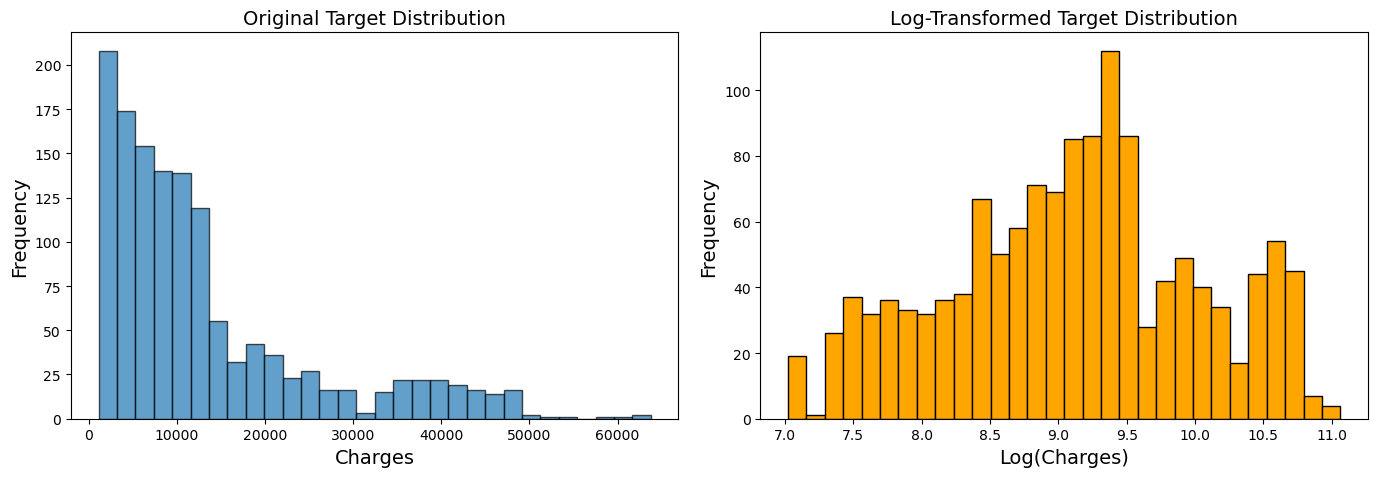

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Charges')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Target Distribution')

axes[1].hist(y_log, bins=30, edgecolor='black', color='orange')
axes[1].set_xlabel('Log(Charges)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Target Distribution')

plt.tight_layout()
plt.show()

In [24]:
X = pd.get_dummies(X, dtype=int, drop_first=True) # drop_first to avoid multicolinearity
X.head()

,age,bmi,children,smoker_age,smoker_bmi,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,19,27.9,0,1,0,0,1
1,18,33.770,1,0,0.0,1,0,0,1,0
2,28,33.000,3,0,0.0,1,0,0,1,0
3,33,22.705,0,0,0.0,1,0,1,0,0
4,32,28.880,0,0,0.0,1,0,1,0,0


In [26]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [27]:
# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1070
Test set size: 268


In [34]:
numerical_cols = ['age', 'bmi', 'children', 'smoker_age', 'smoker_bmi']
categorical_cols = ['sex', 'smoker', 'region']

In [35]:
def create_preprocessing_pipeline(polynomial_degree=1):
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=polynomial_degree, include_bias=False))
    ])

    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])
    
    return preprocessor

In [36]:
def create_full_pipeline(model, polynomial_degree=1):
    preprocessor = create_preprocessing_pipeline(polynomial_degree)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    return pipeline

In [37]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import uniform, loguniform

In [38]:
# Ridge Regression
ridge_param_dist = {
    'preprocessor__num__poly__degree': [1, 2, 3],
    'model__alpha': loguniform(1e-3, 1e3),
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

# Lasso Regression
lasso_param_dist = {
    'preprocessor__num__poly__degree': [1, 2, 3],
    'model__alpha': loguniform(1e-3, 1e3),
    'model__max_iter': [10000, 20000, 50000]
}

# ElasticNet Regression
elasticnet_param_dist = {
    'preprocessor__num__poly__degree': [1, 2, 3],
    'model__alpha': loguniform(1e-3, 1e3),
    'model__l1_ratio': uniform(0, 1),  # Mix between L1 and L2
    'model__max_iter': [10000, 20000, 50000]
}

In [39]:
results = {}

models = {
    'Ridge': (Ridge(random_state=42), ridge_param_dist),
    'Lasso': (Lasso(random_state=42), lasso_param_dist),
    'ElasticNet': (ElasticNet(random_state=42), elasticnet_param_dist)
}

In [40]:
# Perform RandomizedSearchCV for each model
print("Starting hyperparameter tuning...\n")

for model_name, (model, param_dist) in models.items():
    print(f"\n{'='*60}")
    print(f"Tuning {model_name}...")
    print(f"{'='*60}")
    
    # Create pipeline
    pipeline = create_full_pipeline(model)
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings sampled
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # Use all processors
        random_state=42,
        verbose=1
    )
    
    # Fit the model
    random_search.fit(X_train, y_train_log)
    
    # Store results
    results[model_name] = {
        'best_estimator': random_search.best_estimator_,
        'best_params': random_search.best_params_,
        'best_cv_score': -random_search.best_score_,  # Convert back to positive MSE
        'cv_results': random_search.cv_results_
    }
    
    print(f"\nBest parameters for {model_name}:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV MSE: {-random_search.best_score_:.4f}")
    print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")

Starting hyperparameter tuning...


Tuning Ridge...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'sex'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/_indexing.py", line 443, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "/opt/anaconda3/lib/python3.13/site-packages/pandas/core/indexes/base.py", line 3819, in get_loc
    raise KeyError(key) from err
KeyError: 'sex'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ~~~~~~~~~~~~~~~~~~~~~~~~^
        cloned_transformer,
        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
        params=step_params,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/opt/anaconda3/lib/python3.13/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py", line 988, in fit_transform
    self._validate_column_callables(X)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py", line 541, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/_indexing.py", line 451, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [19]:
# Evaluate each model on the test set
evaluation_results = []

for model_name, model_info in results.items():
    best_model = model_info['best_estimator']
    
    # Predictions on log scale
    y_pred_log = best_model.predict(X_test)
    
    # Convert predictions back to original scale
    y_pred = np.exp(y_pred_log)  # expm1 is inverse of log1p
    y_test_original = np.exp(y_test_log)
    
    # Calculate metrics on original scale
    mse_orig = mean_squared_error(y_test_original, y_pred)
    rmse_orig = np.sqrt(mse_orig)
    mae_orig = mean_absolute_error(y_test_original, y_pred)
    r2_orig = r2_score(y_test_original, y_pred)
    
    evaluation_results.append({
        'Model': model_name,
        'RMSE': rmse_orig,
        'MAE': mae_orig,
        'R²': r2_orig,
        'Polynomial Degree': model_info['best_params']['preprocessor__num__poly__degree']
    })

# Create DataFrame for easy comparison
eval_df = pd.DataFrame(evaluation_results)
eval_df = eval_df.round(4)
eval_df

,Model,RMSE,MAE,R²,Polynomial Degree
0,Ridge,4734.2488,2393.6862,0.8556,2
1,Lasso,4467.7336,2192.1370,0.8714,3
2,ElasticNet,4690.6051,2364.1482,0.8583,2


In [20]:
print("\nBest Hyperparameters:")
print("="*100)

for model_name, model_info in results.items():
    print(f"\n{model_name}:")
    for param, value in model_info['best_params'].items():
        print(f"  {param}: {value}")


Best Hyperparameters:

Ridge:
  model__alpha: 5.068612120448909
  model__solver: svd
  preprocessor__num__poly__degree: 2

Lasso:
  model__alpha: 0.008632008168602538
  model__max_iter: 50000
  preprocessor__num__poly__degree: 3

ElasticNet:
  model__alpha: 0.0021800651586435186
  model__l1_ratio: 0.7219987722668247
  model__max_iter: 20000
  preprocessor__num__poly__degree: 2


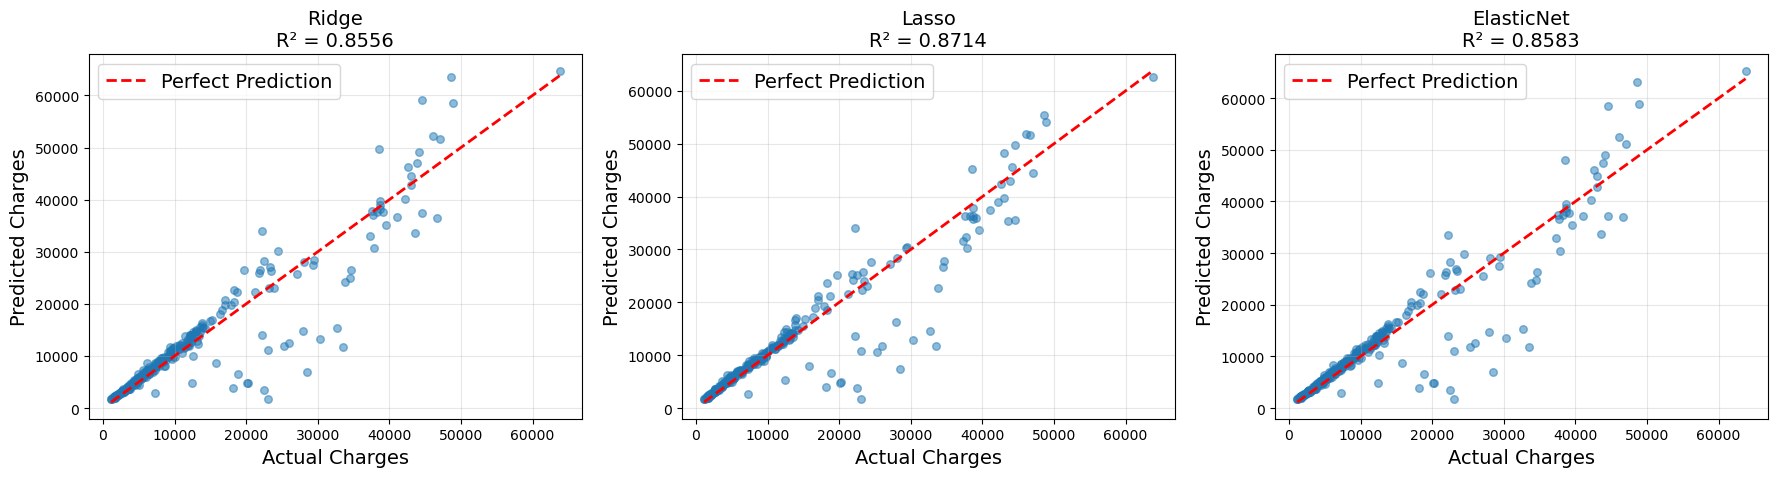

In [21]:
# Predicted vs Actual plots for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, model_info) in enumerate(results.items()):
    best_model = model_info['best_estimator']
    
    # Predictions
    y_pred_log = best_model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_original = np.exp(y_test_log)
    
    # Plot
    axes[idx].scatter(y_test_original, y_pred, alpha=0.5, s=30)
    axes[idx].plot([y_test_original.min(), y_test_original.max()], 
                   [y_test_original.min(), y_test_original.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Charges')
    axes[idx].set_ylabel('Predicted Charges')
    axes[idx].set_title(f'{model_name}\nR² = {eval_df.loc[idx, "R²"]:.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()